In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Data Preprocessing

In [29]:
path_to_data = Path('../data')
# Import only a fraction of data for efficient testing
data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None)
cards = [
# Diamonds
'DA','DK','DQ','DJ','D10','D9','D8','D7','D6',
# Hearts
'HA','HK','HQ','HJ','H10','H9','H8','H7','H6',
# Spades
'SA','SK','SQ','SJ','S10','S9','S8','S7','S6',
# Clubs
'CA','CK','CQ','CJ','C10','C9','C8','C7','C6'
]

# Forehand (yes = 1, no = 0)
forehand = ['FH']

user  = ['user']
trump = ['trump']

feature_columns = cards + forehand

data.columns = cards + forehand + user + trump


### Remve entries with user == 0

In [30]:
data[data['user'] == 0].count()

DA       94455
DK       94455
DQ       94455
DJ       94455
D10      94455
D9       94455
D8       94455
D7       94455
D6       94455
HA       94455
HK       94455
HQ       94455
HJ       94455
H10      94455
H9       94455
H8       94455
H7       94455
H6       94455
SA       94455
SK       94455
SQ       94455
SJ       94455
S10      94455
S9       94455
S8       94455
S7       94455
S6       94455
CA       94455
CK       94455
CQ       94455
CJ       94455
C10      94455
C9       94455
C8       94455
C7       94455
C6       94455
FH       94455
user     94455
trump    94455
dtype: int64

In [31]:
data.drop(data[data['user'] == 0].index, inplace=True)

### Load User Stats

In [32]:
player_stats = pd.read_json(path_to_data / 'stat' / 'player_all_stat.json')
player_stats.head()

,id,mean,std,nr
0,0,78.433100,42.186764,1978858
1,6955,76.191936,41.780344,4241
2,54404,78.010880,41.985297,7445
3,74994,76.775460,41.428476,7669
4,56143,76.774029,41.546253,978


In [33]:
print(f"Mean Max: {player_stats['mean'].max()}")
print(f"Mean Min: {player_stats['mean'].min()}")
print(f"Mean Avg: {player_stats['mean'].mean()}")

print(f"STd Max: {player_stats['std'].max()}")
print(f"STd Min: {player_stats['std'].min()}")
print(f"STd Avg: {player_stats['std'].mean()}")

Mean Max: 140.0
Mean Min: 0.0
Mean Avg: 77.42586010810032
STd Max: 92.63098833543772
STd Min: 0.0
STd Avg: 42.10781643599714


<AxesSubplot:>

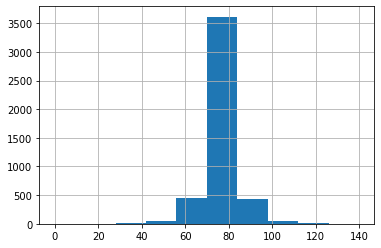

In [34]:
player_stats['mean'].hist()

### Add mean to trump dataset

In [35]:
data = data.merge(player_stats, left_on='user', right_on='id', how='left')

# Drop the columns from player_stats that are not needed
data.drop(columns=['id'], inplace=True)
data.drop(columns=['std'], inplace=True)
data.drop(columns=['nr'], inplace=True)

data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CJ,C10,C9,C8,C7,C6,FH,user,trump,mean
0,0,0,0,1,1,0,1,1,0,0,...,0,0,0,1,0,0,0,53248,6,80.209033
1,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,1,0,0,4613,5,79.254714
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,68780,6,78.182220
3,0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,24555,5,72.863905
4,0,1,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,1,8392,4,80.793806


In [36]:
player_stats['mean'].mean()

77.42586010810032

### Delete entries from bad users

In [37]:
data = data[data['mean'] > 78]#player_stats['mean'].mean()]

### Drop non feature or target variables

In [38]:
data.drop('user', axis='columns', inplace=True)
data.drop('mean', axis='columns', inplace=True)

data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CK,CQ,CJ,C10,C9,C8,C7,C6,FH,trump
0,0,0,0,1,1,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,6
1,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,5
2,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,6
4,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,1,4
5,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,5


## Target Variable 'Trump'

### One-Hot-Encode

In [39]:
data.trump = data.trump.astype('category')
data.trump = data.trump.cat.rename_categories({0: 'DIAMONDS', 1: 'HEARTS', 2: 'SPADES', 3:'CLUBS',
                                  4: 'OBE_ABE', 5: 'UNE_UFE', 6: 'PUSH', 10: 'PUSH'})

data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CK,CQ,CJ,C10,C9,C8,C7,C6,FH,trump
0,0,0,0,1,1,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,PUSH
1,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,UNE_UFE
2,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,PUSH
4,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,1,OBE_ABE
5,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,UNE_UFE


In [40]:
data = pd.get_dummies(data, ['trump', ])
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,C7,C6,FH,trump_DIAMONDS,trump_HEARTS,trump_SPADES,trump_CLUBS,trump_OBE_ABE,trump_UNE_UFE,trump_PUSH
0,0,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,0
5,0,0,1,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0


In [41]:
data.columns

Index(['DA', 'DK', 'DQ', 'DJ', 'D10', 'D9', 'D8', 'D7', 'D6', 'HA', 'HK', 'HQ',
       'HJ', 'H10', 'H9', 'H8', 'H7', 'H6', 'SA', 'SK', 'SQ', 'SJ', 'S10',
       'S9', 'S8', 'S7', 'S6', 'CA', 'CK', 'CQ', 'CJ', 'C10', 'C9', 'C8', 'C7',
       'C6', 'FH', 'trump_DIAMONDS', 'trump_HEARTS', 'trump_SPADES',
       'trump_CLUBS', 'trump_OBE_ABE', 'trump_UNE_UFE', 'trump_PUSH'],
      dtype='object')

## Model

In [42]:
# Split into features (X) and target (y)
X = data[feature_columns]
y = data[
    [
        "trump_DIAMONDS",
        "trump_HEARTS",
        "trump_SPADES",
        "trump_CLUBS",
        "trump_OBE_ABE",
        "trump_UNE_UFE",
        "trump_PUSH",
    ]
]

### Normalization

The normalization is not really necessary, because everything in the dataset is one-hot-encoded

In [43]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize MinMaxScaler
# scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test sets
# X_train_normalized = scaler.fit_transform(X_train)
# X_test_normalized = scaler.transform(X_test)
X_train

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CA,CK,CQ,CJ,C10,C9,C8,C7,C6,FH
63633,0,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,0
49412,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
96190,0,0,0,0,0,1,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
146023,0,0,1,0,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
233123,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184839,0,1,1,0,1,1,1,0,0,0,...,0,0,1,0,0,0,0,0,1,1
160108,0,0,1,0,1,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
202966,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
225604,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(592, input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(Dense(592, activation='relu', kernel_regularizer=keras.regularizers.L2(0.001)))
model.add(keras.layers.Dropout(0.3))
model.add(Dense(7, activation='softmax')) 

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/20
6888/6923 [============================>.] - ETA: 0s - loss: 1.0231 - accuracy: 0.6201

KeyboardInterrupt: 

In [22]:
model.save('trump_model_592.h5')  

In [123]:
# Predict on new data
predictions = model.predict(X_test)
predicted_classes = predictions.argmax(axis=1)  # Convert softmax output to class label
predicted_classes

array([6, 4, 5, ..., 5, 2, 6])

In [ ]:
import numpy as np

# Convert the string of features into integers
single_sample = np.array([int(x) for x in "1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0".split(' ')])

# Reshape the array to match the model's input shape
single_sample = single_sample.reshape(1, -1)

# Make the prediction
prediction = model.predict(single_sample)
print(prediction)


[[0.02379868 0.19412029 0.02367125 0.00458256 0.02668617 0.12759665
  0.5995444 ]]


In [ ]:
X_train

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CA,CK,CQ,CJ,C10,C9,C8,C7,C6,FH
63633,0,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,0,1,0,0
49412,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
96190,0,0,0,0,0,1,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
146023,0,0,1,0,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
233123,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184839,0,1,1,0,1,1,1,0,0,0,...,0,0,1,0,0,0,0,0,1,1
160108,0,0,1,0,1,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
202966,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
225604,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
